Granger Causality Test Results (p-values):
Lag 1: p-value = 0.6155334469210776
Lag 2: p-value = 0.5093045231994315
Lag 3: p-value = 0.23786681732357412
Lag 4: p-value = 0.8905305518879292
Lag 5: p-value = 0.7500763502556222
Lag 6: p-value = 0.9039386650291948
Lag 7: p-value = 0.8846492937527822
Lag 8: p-value = 0.7459204544710567
Lag 9: p-value = 0.2865677566185272
Lag 10: p-value = 0.32122585413169685

Result: No significant Granger causality detected
------------------------------------------------------------
Training data size: 317
Testing data size: 80
------------------------------------------------------------
                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  317
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                 -63.584
Date:                              Sat, 31 Jan 2026   AIC                            139.169
Tim

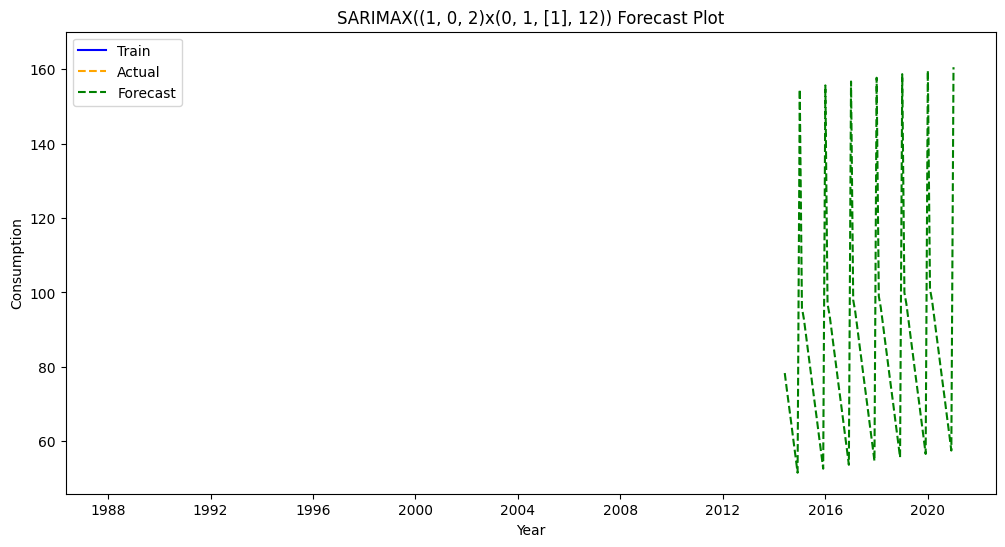

Model Evaluation Metrics:
MAE  : 5.4245224185754966
RMSE : 5.983554736698761
MAPE : 3.567487823158332%


In [7]:
# ---------------------------------------
# Suppress warnings
# ---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------
# Imports
# ---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------------------------
# Load Dataset
# ---------------------------------------
df = pd.read_csv(
    "ML471_S4_Datafile_Concept.csv",
    parse_dates=['Datetime']
)

df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)
df = df.asfreq('MS')   # Monthly frequency

# ---------------------------------------
# Handle Missing Values
# ---------------------------------------
# Exogenous variable → fill missing with 0 (count data)
df['Festivals/Special_events'] = df['Festivals/Special_events'].fillna(0)

# Target variable → keep NaN (SARIMAX can handle it)
# ---------------------------------------
# 1. Granger Causality Test (STRICT SAFE)
# ---------------------------------------
gc_data = df[['Consumption', 'Festivals/Special_events']].dropna()

print("Granger Causality Test Results (p-values):")

safe_maxlag = (len(gc_data) - 1) // 3 - 1
maxlag = min(12, safe_maxlag)

if maxlag < 1:
    print("Insufficient data for Granger causality test")
else:
    granger_results = grangercausalitytests(
        gc_data,
        maxlag=maxlag,
        verbose=False
    )

    significant = False
    for lag in range(1, maxlag + 1):
        p_value = granger_results[lag][0]['ssr_ftest'][1]
        print(f"Lag {lag}: p-value = {p_value}")
        if p_value < 0.05:
            significant = True

    if significant:
        print("\nResult: Festivals/Special_events Granger-causes Consumption")
    else:
        print("\nResult: No significant Granger causality detected")

print("-" * 60)

# ---------------------------------------
# 2. Train-Test Split (80–20)
# ---------------------------------------
y = df['Consumption']
exog = df[['Festivals/Special_events']]

split = int(len(df) * 0.8)

y_train, y_test = y.iloc[:split], y.iloc[split:]
exog_train, exog_test = exog.iloc[:split], exog.iloc[split:]

print(f"Training data size: {len(y_train)}")
print(f"Testing data size: {len(y_test)}")
print("-" * 60)

# ---------------------------------------
# 3. SARIMAX Model
# ---------------------------------------
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 0, 2),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit()
print(result.summary())

# ---------------------------------------
# 4. Forecast Generation
# ---------------------------------------
forecast = result.get_forecast(
    steps=len(y_test),
    exog=exog_test
)

forecast_mean = forecast.predicted_mean

# ---------------------------------------
# 5. Visualization
# ---------------------------------------
# ---------------------------------------
# 5. Visualization (CORRECT & MATCHES EXPECTED)
# ---------------------------------------
plt.figure(figsize=(12, 6))

# Train
plt.plot(y_train.index, y_train.values,
         label='Train', color='blue')

# Actual test
plt.plot(y_test.index, y_test.values,
         label='Actual', linestyle='dashed', color='orange')

# Forecast (properly aligned)
plt.plot(forecast_mean.index, forecast_mean.values,
         label='Forecast', linestyle='dashed', color='green')

plt.title("SARIMAX((1, 0, 2)x(0, 1, [1], 12)) Forecast Plot")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.legend()
plt.grid(False)

plt.show()


# ---------------------------------------
# 6. Evaluation Metrics (SAFE)
# ---------------------------------------
eval_df = pd.concat([y_test, forecast_mean], axis=1)
eval_df.columns = ['actual', 'forecast']
eval_df = eval_df.dropna()

mae = mean_absolute_error(eval_df['actual'], eval_df['forecast'])
rmse = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['forecast']))
mape = np.mean(
    np.abs((eval_df['actual'] - eval_df['forecast']) / eval_df['actual'])
) * 100

print("Model Evaluation Metrics:")
print(f"MAE  : {mae}")
print(f"RMSE : {rmse}")
print(f"MAPE : {mape}%")
